In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
import copy
%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
# Retreive all the data from the meta-data file
#J0600-2020_ASTEP-ANTARCTICA_Rc_measurements.csv : Target calibrated light curve
#J0600-2020_ASTEP-ANTARCTICA_Rc_rawlc.csv : Target and photometric fluxes of reference stars

caldata = ascii.read('../astep/J0600-2020_ASTEP-ANTARCTICA_Rc_measurements.csv')
rawdata = ascii.read('../astep/J0600-2020_ASTEP-ANTARCTICA_Rc_rawlc.csv')
star_info = ascii.read('../astep/CALIB-J0600-2020.csv')
print (star_info)

epoch = rawdata['BJD']
airmass = rawdata['AIRMASS']
sky = rawdata['SKY']
star_mag = star_info['MAG']

J0600_flux = rawdata['TFLUX']
J0600_coords = [90.00316332976436, -31.007910088843165]

flux = []
for i in range(1,6):
    flux.append(rawdata['CFLUX'+str(i)])
flux = np.array(flux).T

 NB   UCAC4     MAG    XC     YC   APER
--- ---------- ----- ------ ------ ----
 C1 296-008997 12.38 2033.4 2385.8    9
 C2 296-009022 12.33 1679.0 2584.5    9
 C3 296-009008  12.7 1838.4 2160.8    9
 C4 295-008892 12.42 2051.6 1756.3    9
 C5 295-008877 13.38 2198.5 1500.5    9


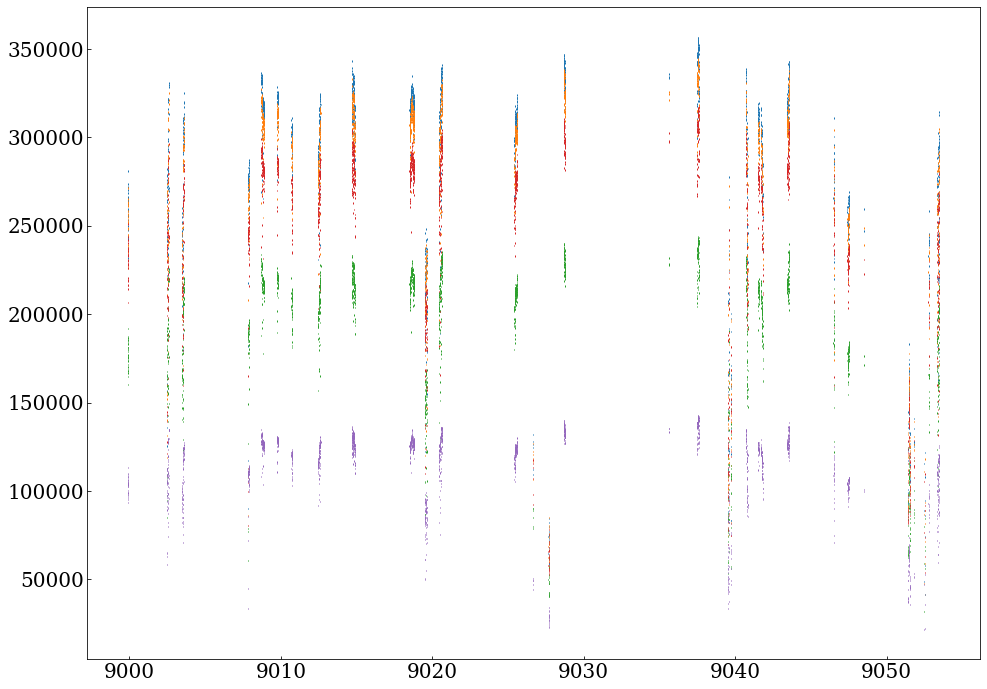

In [58]:
plt.figure(figsize=(16,12))
for s in range(5):
    plt.errorbar(epoch,flux[:,s],yerr=np.sqrt(flux[:,s]),fmt='.',markersize=0,linewidth=1)

In [3]:
star_coords_tmp = np.array([
    [6 + 19.491336/3600, -(30 + 56/60 + 22.20720/3600)],
    [6 + 45.078216/3600, -(30 + 53/60 + 13.82208/3600)],
    [6 + 33.819120/3600, -(30 + 59/60 + 50.89200/3600)],
    [6 + 18.551304/3600, -(31 +  6/60 + 11.49732/3600)],
    [6 + 08.019888/3600, -(31 + 10/60 + 11.48808/3600)]
])
star_coords = copy.copy(star_coords_tmp)
star_coords[:,0] = star_coords[:,0] /24 * 360 # from hr to degrees

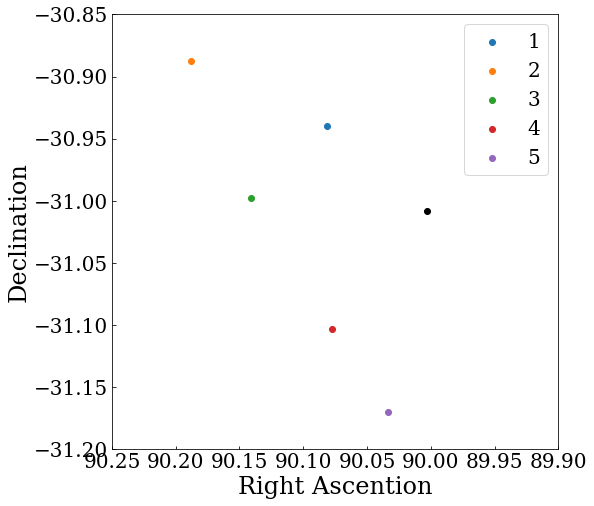

[0.10378612 0.22063036 0.13814473 0.12072606 0.1647492 ]


In [9]:
plt.figure(figsize=(8,8))
for s in range(5):
    plt.scatter(star_coords[s,0],star_coords[s,1],label=str(s+1))
plt.scatter([90.00316332976436], [-31.007910088843165], c='black')
plt.legend()
plt.ylim(-31.20,-30.85)
plt.xlim(90.25,89.90)
plt.xlabel("Right Ascention")
plt.ylabel("Declination")
plt.show()

# Find Gaia colours of the reference stars

In [5]:
# To link the correct Gaia entries to our stars, select star with nearest coordinates
def find_stars(xobj_list, yobj_list, xlist, ylist):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    """
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=4)
    plt.scatter(xobj_list, yobj_list, c='red', s=2)
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title(f)
    plt.show()
    """
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

def distance(xobj,yobj, xlist,ylist):
    'find the distance between target & objects round it, returns list with distances in pixels'
    d = (xobj-xlist)**2 + (yobj-ylist)**2
    return np.sqrt(d)


In [10]:
# Extract the magnitudes from the stars in 400" radius around J0600
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Coords of J0600: 90.00316332976436 -31.007910088843165
coord = SkyCoord(ra=90.003163, dec=-31.007910, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(0.25, u.degree)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
r.pprint()

INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2891196718939580672 ... 0.00013201426578689563
1635721458409799680 Gaia DR2 2891196684579844864 ...   0.009094052279059428
1635721458409799680 Gaia DR2 2891196753298345472 ...   0.010658205399898254
1635721458409799680 Gaia DR2 2891196684579845376 ...   0.011317279008876314
1635721458409799680 Gaia DR2 2891196753297490304 ...   0.012358430209092582
1635721458409799680 Gaia DR2 2891196920800325760 ...   0.013193050363307734
1635721458409799680 Gaia DR2 2891196753299317632 ...   0.013872023467184842
1635721458409799680 Gaia DR2 2891196680282145152 ...    0.01664899863064252
1635721458409799680 Gaia DR2 2891196684578034688 ...   0.016696369787614993
1635721458409799680 Gaia DR2 289119692

In [23]:
# Making a mask for the gaia data to extract the data from the relevant stars
stars_arg, d = find_stars(star_coords[:,0],star_coords[:,1],np.array(r['ra']),np.array(r['dec']))
gaiamask = stars_arg
max_d = 1/3600 #if distance is bigger than 1", it is to much
if np.sum(d >= max_d) != 0:
    print ("Stars that are too distant")
    print (np.arange(5)[d >= max_d])

# Get the gaia-colours for the selected stars in all filters
gaia_c = np.array(r['phot_rp_mean_mag'][gaiamask]) - np.array(r['phot_g_mean_mag'][gaiamask])

# Extract the Gaia J0600 data
# Coords of J0600: 90.00316332976436 -31.007910088843165
d = distance(90.00316332976436, -31.007910088843165, r['ra'],r['dec'])
J0600_gaia = r[np.argmin(d)]

# Extract gaia magnitudes & colour for J0600
#J0600_gaiamag = {}
#J0600_gaiamag[filt[0]] = J0600_gaia['phot_g_mean_mag'] #gaia filter g, not gp
#J0600_gaiamag[filt[2]] = J0600_gaia['phot_rp_mean_mag']

J0600_c = J0600_gaia['phot_rp_mean_mag']-J0600_gaia['phot_g_mean_mag']


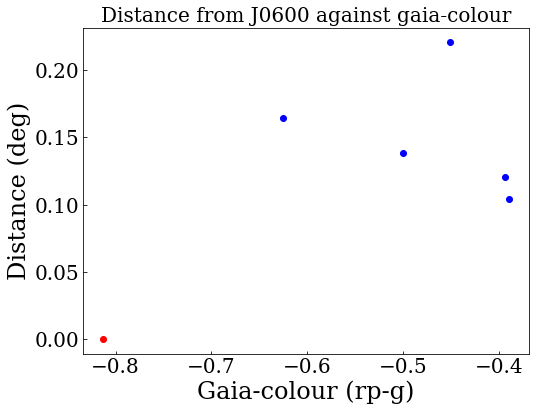

In [24]:
plt.scatter(gaia_c, distance(90.00316332976436, -31.007910088843165, star_coords[:,0],star_coords[:,1]),c='b')
plt.scatter(J0600_c,[0],c='r')
plt.title("Distance from J0600 against gaia-colour")
plt.xlabel("Gaia-colour (rp-g)")
plt.ylabel("Distance (deg)")
plt.show()

In [25]:
# test of calibrated data
#plt.errorbar(caldata['BJD'],caldata['FLUX'],yerr=caldata['ERRFLUX'],fmt='.')
#plt.gca().invert_yaxis()
#plt.show()

In [52]:
mx = -2.5*np.log10(flux)
mxerr = (2.5/np.log(10))*(fluxerr/flux)
J0600_mx = -2.5*np.log10(J0600_flux)

NameError: name 'fluxerr' is not defined

In [42]:
from scipy import optimize

# m_true = m_inst + b0c + b1c^2 + ...
# m_inst = m_x + a0X + a1cX
# m_true = m_x + a0X + a1cX + a2c + a3c^2 + ...

def atmosph_ext(M, a0,a1,a2,a3):
    
    return M + a0 + (a1*c) + (a2*(c**2)) + (a3*(c**3))# + (a4*(c**4))

tmp1 = []
tmp2 = []
for e in range(len(epoch)):

    X = airmass[e]
    M = mx[e]
    c = copy.copy(gaia_c)

    #popt, pcov = optimize.curve_fit(atmosph_ext,M, star_mag, p0=[27,0,0],\
    #                                bounds=([0,-0.02,-0.02],[50,0.02,0.02],))
    popt, pcov = optimize.curve_fit(atmosph_ext,M, star_mag, p0=[27,0,0,0],\
                                    bounds=([0,-10,-10,-10],[50,10,10,10],))
    #popt, pcov = optimize.curve_fit(atmosph_ext,M, star_mag)#, p0=[27],bounds=([0],[50]))


    tmp1.append(np.array(popt))
    tmp2.append(np.sqrt(np.diag(pcov)))
fit_result = np.array(tmp1)
fit_resulterr = np.array(tmp2)
print (fit_result)
print (fit_resulterr)


[[25.9067819   0.27608176 -0.66080663 -1.65636924]
 [25.93528325  0.17213811 -0.50500065 -1.19336237]
 [25.95787746  0.11203139 -0.5429111  -1.05634174]
 ...
 [26.05774642  0.18749067  0.12574512 -0.15664004]
 [25.75940169  0.30302939  0.21564035 -0.27754839]
 [26.11461264  0.30226256  0.28238993 -0.28304997]]
[[3.87289866e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.97552391e-02 1.54287364e-01 0.00000000e+00 0.00000000e+00]
 [9.95950433e-02 2.38077690e-01 0.00000000e+00 0.00000000e+00]
 ...
 [1.26492451e-01 2.20823327e-01 9.62546565e-01 8.83293306e-01]
 [6.01200783e-02 2.31785800e-15 4.91770080e-01 5.42596765e-01]
 [3.68267736e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


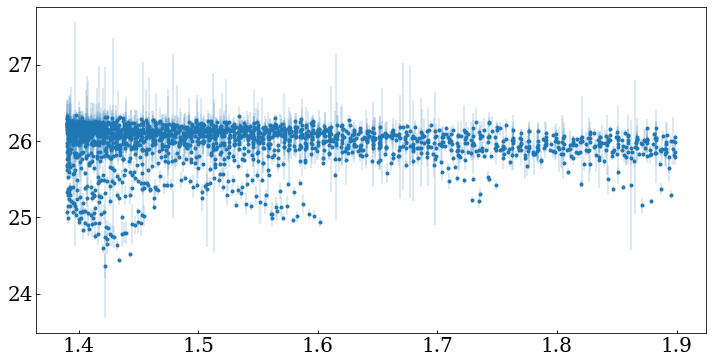

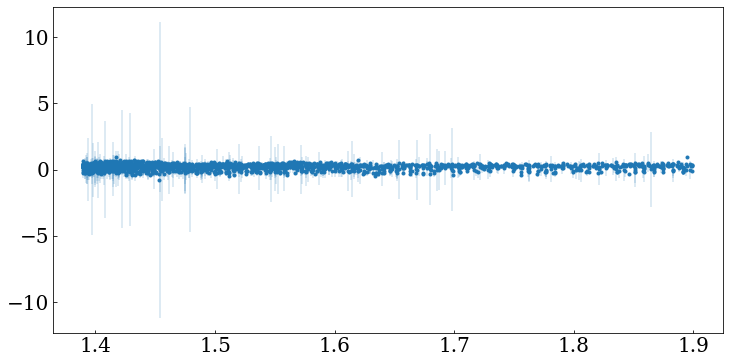

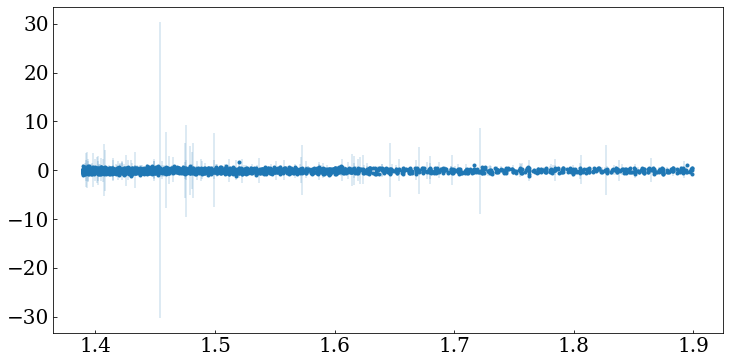

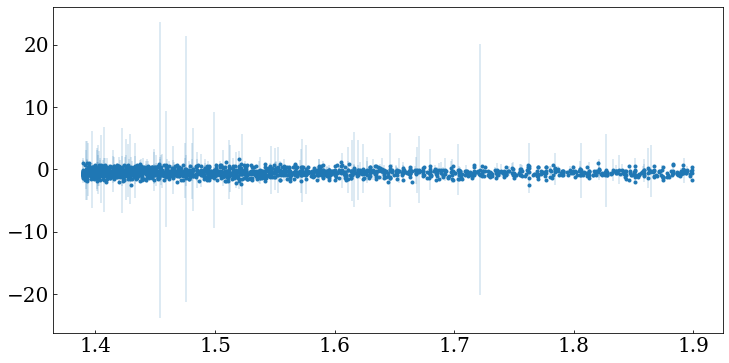

[26.04499558  0.25795593 -0.12441855 -0.48107541]


In [43]:
for i in range(len(fit_result[0])):
    plt.figure(figsize=(12,6))
    plt.errorbar(airmass,fit_result[:,i],yerr=fit_resulterr[:,i],fmt='.', linewidth=0.3)
    plt.show()

print (np.median(fit_result,axis=0))


In [44]:
tmp1 = []
tmp2 = []
for e in range(len(epoch)):
    c = copy.copy(gaia_c)
    tmp1.append(atmosph_ext(mx[e],*fit_result[e]))
    c = copy.copy(J0600_c)
    tmp2.append(atmosph_ext(J0600_mx[e],*fit_result[e]))
mag = np.array(tmp1)
J0600_mag = np.array(tmp2)

print (fit_result[e])

print (mag)
print (J0600_mag)

[26.11461264  0.30226256  0.28238993 -0.28304997]
[[12.30329501 12.35472602 12.72416022 12.4380303  13.38978945]
 [12.30620921 12.34788436 12.72718969 12.44523741 13.37951037]
 [12.33985707 12.34939821 12.72883629 12.44239181 13.34949747]
 ...
 [12.33211803 12.35108388 12.74774702 12.44494075 13.33550081]
 [12.3123888  12.36031754 12.72287304 12.45357157 13.35958484]
 [12.31838463 12.35849172 12.73465966 12.44126003 13.35720651]]
[13.81891498 13.73669469 13.68220127 ... 13.48463068 13.53012474
 13.58396091]


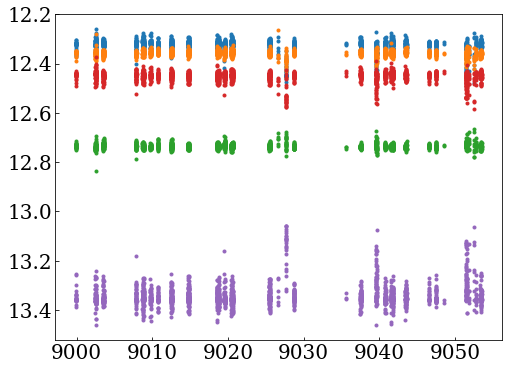

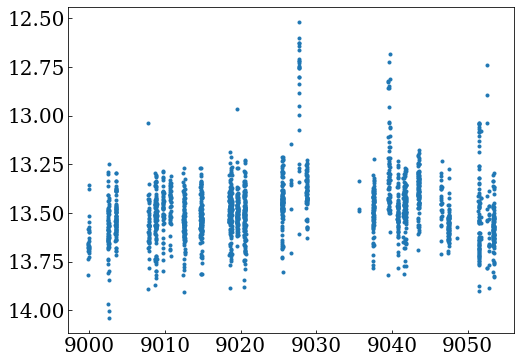

In [45]:
for s in range(5):
    #plt.plot([np.min(epoch),np.max(epoch)], [star_mag[s]]*2, linestyle='--')
    plt.errorbar(epoch,mag[:,s],fmt='.')
plt.gca().invert_yaxis()
plt.show()

plt.errorbar(epoch,J0600_mag,fmt='.')
plt.gca().invert_yaxis()
plt.show()

# Trying the differential photometry atmospheric correction

In [31]:
# Let's skip this first two steps


In [32]:
initialw = np.nanmedian(flux,axis=0)
print (initialw)
    
def ALC_func(F,ep, inw, w):
    tmp = []
    
    for e in range(len(ep)):
        noNaN = np.isnan(F[e]) == False
        ALC_i = np.sum(((F[e]*w)/(inw))[noNaN]) / np.sum(w[noNaN])
        tmp.append(ALC_i)
        
    return np.array(tmp)

ALC = ALC_func(flux,epoch, initialw, initialw)
print (ALC)

[302707.2 293392.5 207422.5 269549.1 120918.5]
[0.82060919 0.86873054 0.88722433 ... 0.98653004 0.73664708 1.03551094]


In [33]:
def weight_func(F, ep, inw, ALC):
    
    w_ij = []
    for e in range(len(ep)):
        w_j = ((F[e]/inw) *(1/(ALC[e])))
        w_ij.append(w_j)
    w_ij = np.array(w_ij)
    
    return (1/np.sqrt(np.nanmean((w_ij-np.nanmean(w_ij,axis=0))**2,axis=0)))**2 

#neww = {}
#for f in filt:
#    neww[f] = weight_func(newflux[f],corepoch[f],initialw[f],ALC[f])

In [39]:
i = 0

test = []

while i < 60:
    i += 1
    
    neww = weight_func(flux,epoch,initialw,ALC)
    test.append(neww)
    
    ALC = ALC_func(flux,epoch, initialw, neww)
    


In [46]:
def RMS(arr):
    return np.sqrt(np.nanmean((np.nanmean(arr)-arr)**2))

In [51]:
tmp = []
for s in range(5):
    tmp.append(RMS(flux[:,s]/ALC))
print (np.array(tmp))
print (np.shape(np.array(tmp)))

[1785.31399132 2076.68620965 1619.10979106 1789.97635872 1561.0537465 ]
(5,)


In [40]:
# Check if wights converge within 1e-5


#for i in range(1,50):
#    plt.plot(np.array(test[i-1])-np.array(test[i]))
    #plt.yscale('log')
#plt.ylim([-1e-5,1e-5])
#    plt.show()


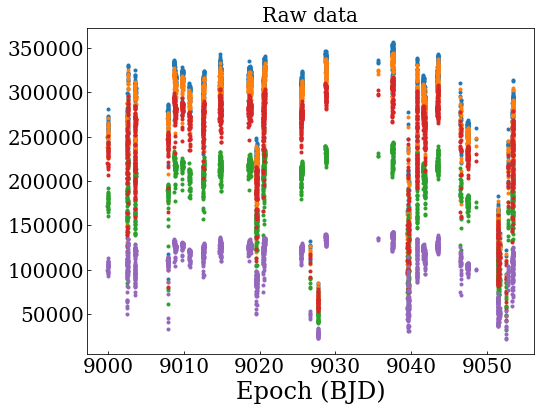

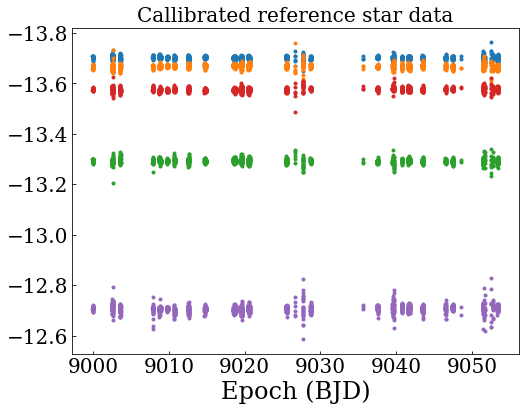

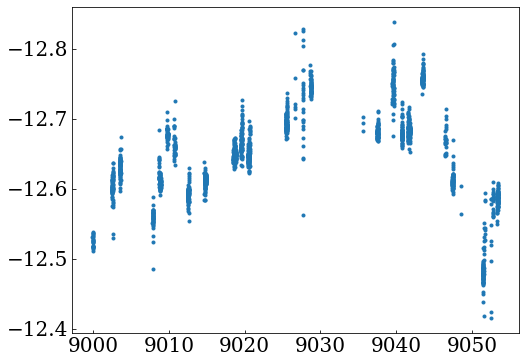

In [41]:
for s in range(5):
    plt.errorbar(epoch,flux[:,s],fmt='.')
#plt.gca().invert_yaxis()
plt.title("Raw data")
plt.xlabel("Epoch (BJD)")
plt.show()

for s in range(5):
    plt.errorbar(epoch,-2.5*np.log10(flux[:,s]/ALC),fmt='.')
    
plt.gca().invert_yaxis()
plt.title("Callibrated reference star data")
plt.xlabel("Epoch (BJD)")
plt.show()

plt.errorbar(epoch,-2.5*np.log10(J0600_flux/ALC),fmt='.')
plt.gca().invert_yaxis()
plt.show()